# Hate Speech Detection

Nefret söyleminin yasal bir tanımı yoktur çünkü insanların görüşleri kolayca nefret dolu veya saldırgan olarak sınıflandırılamaz. Bununla birlikte, Birleşmiş Milletler nefret söylemini, bir kişiye veya bir grup insana, din, etnik köken, milliyet, ırk, renk, soy, cinsiyet veya başka herhangi bir kimlik faktörüne dayalı kimliklerine göre saldırabilen veya ayrımcı dil kullanabilen her türlü sözlü, yazılı veya davranışsal iletişim olarak tanımlar.<br>
Bu projemizde tweetlerdeki nefret söylemlerini tespit eden bir model geliştireceğiz.

<img src="https://www.saglik.news/wp-content/uploads/2024/03/nfrtsylm-780x470.jpg">

<a href="https://thecleverprogrammer.com/2021/07/25/hate-speech-detection-with-machine-learning/">Dataya Buradan Erişebilirsniz</a>

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [43]:
df=pd.read_csv("twitter.csv")

In [44]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [45]:
d={0:"Nefret söylemi",1:"Saldırgan Dil",2:"Normal"}

In [46]:
df["label"]=df["class"].map(d)

In [47]:
df=df[["label","tweet"]]

In [48]:
df.head()

,label,tweet
0,Normal,!!! RT @mayasolovely: As a woman you shouldn't...
1,Saldırgan Dil,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,Saldırgan Dil,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,Saldırgan Dil,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,Saldırgan Dil,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


#### Wordcloud

In [81]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
import numpy as np

In [82]:
def wc(data,bgcolor):
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor, stopwords=STOPWORDS)
    wc.generate(" ".join(data))  # join Metindeki satırları birleştiri - generate En çok tekrar edenleri saydı
    plt.imshow(wc)
    plt.axis("off")

In [86]:
nefret=df[df["label"]=="Nefret söylemi"]["tweet"]

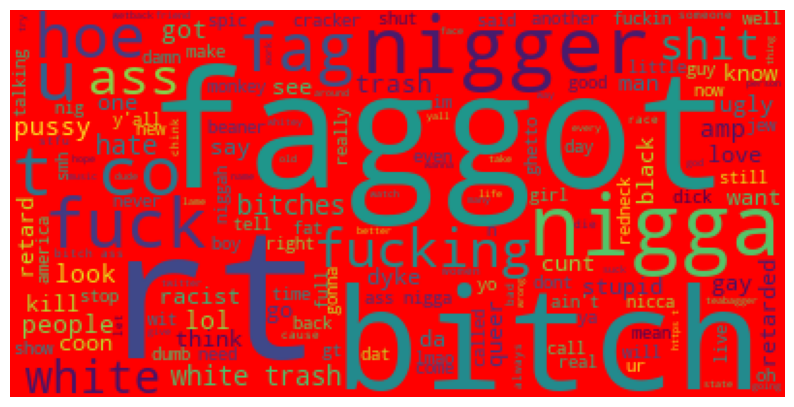

In [87]:
wc(nefret,"red")

In [88]:
saldirgan=df[df["label"]=="Saldırgan Dil"]["tweet"]

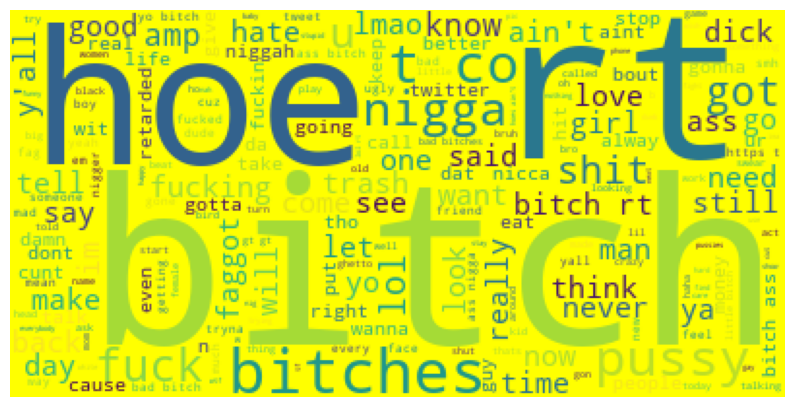

In [89]:
wc(saldirgan,"yellow")

In [90]:
normal=df[df["label"]=="Normal"]["tweet"]

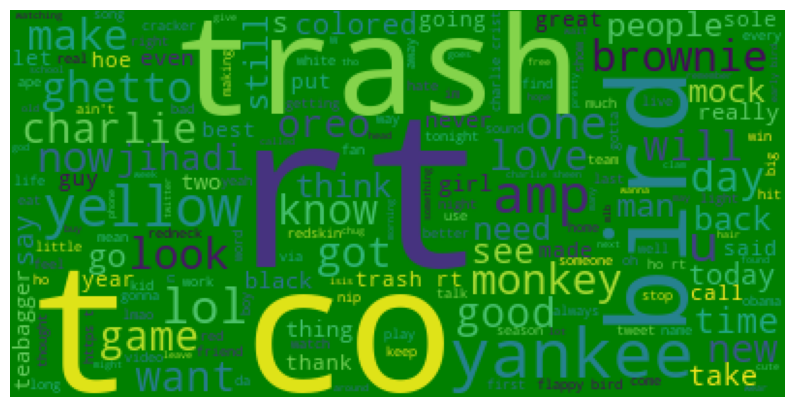

In [91]:
wc(normal,"green")

#### Model

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [51]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [52]:
from textblob import TextBlob

In [53]:
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [54]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [55]:
vect=CountVectorizer(stop_words="english", ngram_range=(1,2),max_features=10000, analyzer=lemmafn)

In [56]:
df["tweet"]=df["tweet"].str.lower()
df["tweet"]=df["tweet"].str.replace("[^\w\s]","")
df["tweet"]=df["tweet"].str.replace("\n","")
df["tweet"]=df["tweet"].str.replace("\d+","")
df["tweet"]=df["tweet"].str.replace("\r","")

In [57]:
x=df["tweet"]
y=df["label"]

In [58]:
x=vect.fit_transform(x)

In [59]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42,test_size=.20)

In [60]:
d=DecisionTreeClassifier()

In [61]:
d.fit(x_train,y_train)

DecisionTreeClassifier()

In [62]:
pred=d.predict(x_test)

In [63]:
accuracy_score(pred,y_test)

0.8757312890861408

#### Pipeline

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [66]:
clf=Pipeline([("tfidf",TfidfVectorizer()),("classifier",RandomForestClassifier())])

In [67]:
x=df["tweet"]
y=df["label"]

In [68]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.2)

In [69]:
clf.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier', RandomForestClassifier())])

In [70]:
y_pred=clf.predict(x_test)

In [71]:
accuracy_score(y_test,y_pred)

0.8587855557797055

In [72]:
from sklearn.svm import SVC

In [73]:
svm=Pipeline([("tfidf",TfidfVectorizer()),("classifier",SVC())])

In [74]:
svm.fit(x_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('classifier', SVC())])

In [75]:
y_pred=svm.predict(x_test)

In [76]:
accuracy_score(y_test,y_pred)

0.8940891668347791

<Axes: >

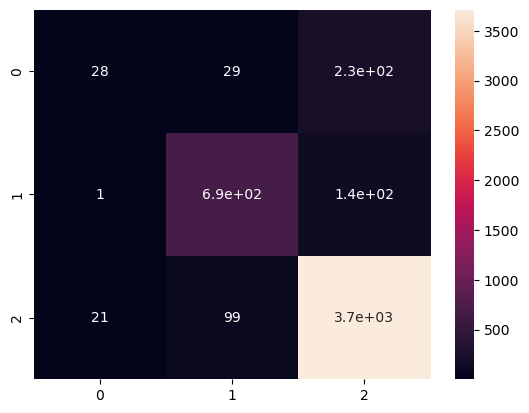

In [79]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)

In [80]:
print(classification_report(y_test,y_pred))

                precision    recall  f1-score   support

Nefret söylemi       0.56      0.10      0.16       290
        Normal       0.84      0.83      0.84       835
 Saldırgan Dil       0.91      0.97      0.94      3832

      accuracy                           0.89      4957
     macro avg       0.77      0.63      0.65      4957
  weighted avg       0.88      0.89      0.88      4957



In [96]:
df.head()

,label,tweet
0,Normal,!!! rt @mayasolovely: as a woman you shouldn't...
1,Saldırgan Dil,!!!!! rt @mleew17: boy dats cold...tyga dwn ba...
2,Saldırgan Dil,!!!!!!! rt @urkindofbrand dawg!!!! rt @80sbaby...
3,Saldırgan Dil,!!!!!!!!! rt @c_g_anderson: @viva_based she lo...
4,Saldırgan Dil,!!!!!!!!!!!!! rt @shenikaroberts: the shit you...


In [102]:
df["tweet"][3]

'!!!!!!!!! rt @c_g_anderson: @viva_based she look like a tranny'

In [98]:
text='!!!!!!!!! rt @c_g_anderson: @viva_based she look like a tranny'

In [99]:
print(svm.predict([text])) 

['Saldırgan Dil']


In [100]:
import pickle

# Modeli kaydetme
with open('nefret_soylemi.pkl', 'wb') as file:
    pickle.dump(svm, file)

Sonuc olarak wordcloud larımızı olusturup tweetlerdeki nefret söylemlerini tespit eden bir model olusturduk ve modelimizi eğittik. Ve bir streamlit uygulamasi yapmak üzere kaydettik.